# ELL793 Assignment 4
**Object Detection using Faster RCNN + Visualizing Results** <br>
Abhinava Sikdar 2017MT01724 <br>
Yashank Singh 2017MT10756

In [ ]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import cv2

print('Is CUDA available', torch.cuda.is_available())
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))
#https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
#https://www.kaggle.com/abhishek/training-fast-rcnn-using-torchvision

Is CUDA available True
Torch 1.7.0+cu101 CUDA 10.1
Device: cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#https://colab.research.google.com/github/pytorch/vision/blob/temp-tutorial/tutorials/torchvision_finetuning_instance_segmentation.ipynb#scrollTo=-WXLwePV5ieP
!git clone https://github.com/pytorch/vision.git
!cd vision
!git checkout v0.3.0

!cp /content/vision/references/detection/utils.py ../usr/lib/python3.6
!cp /content/vision/references/detection/transforms.py ../usr/lib/python3.6
!cp /content/vision/references/detection/coco_eval.py ../usr/lib/python3.6
!cp /content/vision/references/detection/engine.py ../usr/lib/python3.6
!cp /content/vision/references/detection/coco_utils.py ../usr/lib/python3.6

fatal: destination path 'vision' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git


In [ ]:
dev=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#https://github.com/pytorch/vision/blob/master/references/detection/engine.py
#https://github.com/pytorch/vision/blob/master/references/detection/utils.py
from engine import evaluate,train_one_epoch
import utils
import transforms as T

In [ ]:
def return_class(class_name):
    classes=['background','person','bird', 'cat', 'cow', 'dog', 'horse', 'sheep', 'aeroplane', 'bicycle', 'boat', 'bus', 'car', 'motorbike', 'train', 'bottle', 'chair', 'diningtable', 'pottedplant', 'sofa', 'tvmonitor']
    return classes.index(class_name)

def return_class_name(class_name):
    classes=['background','person','bird', 'cat', 'cow', 'dog', 'horse', 'sheep', 'aeroplane', 'bicycle', 'boat', 'bus', 'car', 'motorbike', 'train', 'bottle', 'chair', 'diningtable', 'pottedplant', 'sofa', 'tvmonitor']
    return classes[class_name]

In [ ]:
class VOC_Dataset(torch.utils.data.Dataset):
  def __init__(self, dataset, transforms=None):
    self.transforms = transforms
    self.dataset=dataset
  
  def __getitem__(self,ind):
    boxes=[]
    names=[]
    img,dic =self.dataset[ind]
    for i in range(len(dic['annotation']['object'])):
      xmax=int(dic['annotation']['object'][i]['bndbox']['xmax'])
      xmin=int(dic['annotation']['object'][i]['bndbox']['xmin'])
      ymax=int(dic['annotation']['object'][i]['bndbox']['ymax'])
      ymin=int(dic['annotation']['object'][i]['bndbox']['ymin'])
      boxes.append([xmin, ymin, xmax, ymax])
      names.append(return_class(dic['annotation']['object'][i]['name']))
    
    target={}
    target['boxes']=torch.as_tensor(boxes,dtype=torch.float32)
    target['labels']=torch.as_tensor(names,dtype=torch.int64)
    target['image_id'] = torch.tensor(int(dic['annotation']['source']['flickrid']),dtype=torch.int64)
    target['area']=(target['boxes'][:, 3] - target['boxes'][:, 1]) * (target['boxes'][:, 2] - target['boxes'][:, 0])
    target['iscrowd']=torch.zeros((len(dic['annotation']['object']),), dtype=torch.int64)
    return img,target

  def __len__(self):
    return len(self.dataset)

In [ ]:
data_path='../data/'
voc_train_tem=datasets.VOCDetection(data_path, year='2007', image_set='train', download=True, transform=transforms.ToTensor())
voc_test_tem=datasets.VOCDetection(data_path, year='2007', image_set='trainval',download=True, transform=transforms.ToTensor())

Using downloaded and verified file: ../data/VOCtrainval_06-Nov-2007.tar


KeyboardInterrupt: ignored

In [ ]:
voc_train=VOC_Dataset(dataset=voc_train_tem)
voc_test=VOC_Dataset(dataset=voc_test_tem)

In [ ]:
print(len(voc_test))
img,lab=voc_test_tem[31]
plt.axis('off')
plt.imshow(img.permute(1,2,0))
#plt.savefig('voc6.jpg',bbox_inches='tight',pad_inches=0, dpi=100)

In [ ]:
train_loader=torch.utils.data.DataLoader(voc_train,batch_size=2,shuffle=True, num_workers=0,collate_fn=utils.collate_fn)
test_loader=torch.utils.data.DataLoader(voc_test,batch_size=2,shuffle=False, num_workers=0,collate_fn=utils.collate_fn)

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_fasterRCNN(num_classes):
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=False,progress=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
model=get_fasterRCNN(20+1)
model=model.to(dev)

optimizer= torch.optim.Adam(model.parameters(),lr=0.00001)
num_epochs=20

In [ ]:
print_freq=1000

for i in range(num_epochs):
  j=0
  for images, targets in train_loader:
    j=j+train_loader.batch_size
    images = list(image.to(dev) for image in images)
    targets = [{k: v.to(dev) for k, v in t.items()} for t in targets]
    model=model.train()
    out= model(images,targets)
    l1,l2,l3,l4=out['loss_classifier'],out['loss_box_reg'],out['loss_objectness'],out['loss_rpn_box_reg']
    loss=l1+l2+l3+l4
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if j%print_freq==0:
      print("Epoch: %d, Progress: %d/%d, Loss: %f, loss_classifier: %f, loss_box_reg: %f, loss_objectness: %f, loss_rpn_box_reg: %f" % (i, j,len(train_loader.dataset),float(loss),float(l1),float(l2),float(l3),float(l4)))
  #train_one_epoch(model, optimizer, train_loader, dev, i, print_freq=20)

  evaluate(model,test_loader,dev)
  torch.save(model, '/content/gdrive/MyDrive/FasterRCNN/model'+str(i)+'.pth')


In [ ]:
model=torch.load('/content/gdrive/MyDrive/FasterRCNN/model19.pth')

In [ ]:
model=model.eval()
model=model.to(dev)

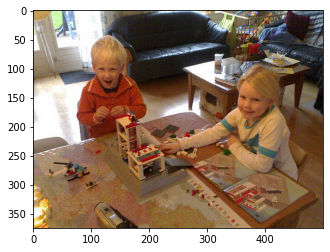

In [ ]:
j=1017
img,lab=voc_test[j]
plt.imshow(img.permute(1,2,0))

In [ ]:
img=img.to(dev)
out=model(img.unsqueeze(0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


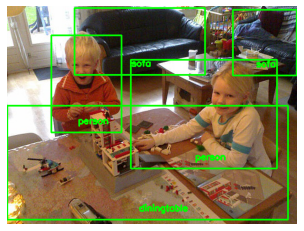

In [ ]:
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 0.5
color = (0, 225, 0)
thickness = 2

sample=img.permute(1,2,0).cpu().numpy()
for i in range(len(out[0]['scores'])):
  if out[0]['scores'][i]>0.5:
    sample=cv2.rectangle(sample,(out[0]['boxes'][i][0],out[0]['boxes'][i][1]),(out[0]['boxes'][i][2],out[0]['boxes'][i][3]),color, thickness=2)
    sample=cv2.putText(sample, return_class_name(int(out[0]['labels'][i].cpu())), ((out[0]['boxes'][i][2]+out[0]['boxes'][i][0])/2-15,out[0]['boxes'][i][3]-15), font, fontScale, color, thickness, cv2.LINE_AA, False) 
plt.axis('off')
plt.imshow(cv2.UMat.get(sample))
plt.savefig(str(j)+'.png',bbox_inches='tight',dpi=200,pad_inches=0)